# Training pipeline for MFCC (train + save)

In [1]:
import sys
import os
from git_root import git_root

import numpy as np
import tensorflow as tf

from tensorflow.keras.optimizers import Adam

sys.path.append(git_root("utils"))
from utils import load_params

from fetch_data import fetch_data_local
from fetch_data import to_numpy_arrays, prepare_tf_dataset

sys.path.append(git_root("models"))
from MFCC_model import setup_model

from validation_utils import plot_history

In [2]:
print(tf.__version__)

2.0.0


In [3]:
params = load_params()

In [4]:
train = fetch_data_local(map_type="mfcc", train=True)
test = fetch_data_local(map_type="mfcc", train=False)

Fetching: data_mfcc_train.json
Fetching: data_mfcc_test.json


In [5]:
print("train")
print(train.shape)
print("test")
print(test.shape)

train
(900, 3)
test
(100, 3)


In [6]:
np.array(train.loc[0,'maps']).shape

(30, 40, 50)

In [7]:
len(train.iloc[0, 1])

30

In [8]:
train = to_numpy_arrays(train, mfcc=True)
test = to_numpy_arrays(test, mfcc=True)

In [9]:
print("train")
print(len(train[0]))
print(len(train[1]))
print("test")
print(len(test[0]))
print(len(test[1]))

train
900
900
test
100
100


In [10]:
train_sample_unstacked = []
train_label_unstacked = []

for j in range(len(train[0])):
    train_sample_unstacked += [train[0][j][:,:,i].reshape(40,50,1) for i in range(train[0][0].shape[-1])]

for i in range(len(train[1])):
    train_label_unstacked += [train[1][i]]*(train[0][0].shape[-1])

In [11]:
test_sample_unstacked = []
test_label_unstacked = []

for j in range(len(test[0])):
    test_sample_unstacked += [test[0][j][:,:,i].reshape(40,50,1) for i in range(test[0][0].shape[-1])]

for i in range(len(test[1])):
    test_label_unstacked += [test[1][i]]*(test[0][0].shape[-1])

In [12]:
train = prepare_tf_dataset(train_sample_unstacked, train_label_unstacked)
test = prepare_tf_dataset(test_sample_unstacked, test_label_unstacked)

In [13]:
tr_sample_batch, tr_label_batch = next(iter(train))
te_sample_batch, te_label_batch = next(iter(test))
print("train")
print(tr_sample_batch.shape, tr_label_batch.shape)
print("test")
print(te_sample_batch.shape, te_label_batch.shape)

train
(32, 40, 50, 1) (32,)
test
(32, 40, 50, 1) (32,)


In [14]:
#We load the model
net = setup_model()
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 31, 41, 12)        1212      
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 7, 10, 12)         0         
_________________________________________________________________
affine (AffineScalar)        (None, 7, 10, 12)         2         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 8, 12)          1308      
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                130       
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
______________________________________________________

In [15]:
net.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = net.fit(train, epochs=800, validation_data=test)

Epoch 1/800
844/844 [==============================] - 22s 26ms/step - loss: 2.2796 - accuracy: 0.1589 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/800
844/844 [==============================] - 19s 23ms/step - loss: 2.3261 - accuracy: 0.1040 - val_loss: 2.2919 - val_accuracy: 0.1220
Epoch 3/800
844/844 [==============================] - 19s 22ms/step - loss: 2.2863 - accuracy: 0.1497 - val_loss: 2.2965 - val_accuracy: 0.1163
Epoch 4/800
844/844 [==============================] - 19s 23ms/step - loss: 2.2901 - accuracy: 0.1563 - val_loss: 2.2804 - val_accuracy: 0.1413
Epoch 5/800
844/844 [==============================] - 19s 23ms/step - loss: 2.2793 - accuracy: 0.1343 - val_loss: 2.2616 - val_accuracy: 0.1483
Epoch 6/800
844/844 [==============================] - 19s 22ms/step - loss: 2.2551 - accuracy: 0.1458 - val_loss: 2.2810 - val_accuracy: 0.1390
Epoch 7/800
844/844 [==============================] - 19s 22ms/step - loss: 2.2536 - accuracy: 0.1663 - val_loss: 2.2765 

844/844 [==============================] - 18s 21ms/step - loss: 1.9494 - accuracy: 0.2859 - val_loss: 2.0096 - val_accuracy: 0.2710
Epoch 114/800
844/844 [==============================] - 18s 21ms/step - loss: 1.9485 - accuracy: 0.2865 - val_loss: 2.0102 - val_accuracy: 0.2730
Epoch 115/800
844/844 [==============================] - 18s 21ms/step - loss: 1.9480 - accuracy: 0.2866 - val_loss: 2.0083 - val_accuracy: 0.2727
Epoch 116/800
844/844 [==============================] - 18s 21ms/step - loss: 1.9479 - accuracy: 0.2870 - val_loss: 2.0033 - val_accuracy: 0.2737
Epoch 117/800
844/844 [==============================] - 18s 21ms/step - loss: 1.9471 - accuracy: 0.2885 - val_loss: 1.9984 - val_accuracy: 0.2740
Epoch 118/800
844/844 [==============================] - 17s 21ms/step - loss: 1.9465 - accuracy: 0.2885 - val_loss: 1.9931 - val_accuracy: 0.2743
Epoch 119/800
844/844 [==============================] - 18s 21ms/step - loss: 1.9445 - accuracy: 0.2914 - val_loss: 1.9901 - val_ac

Epoch 169/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8942 - accuracy: 0.3331 - val_loss: 1.9505 - val_accuracy: 0.2820
Epoch 170/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8926 - accuracy: 0.3336 - val_loss: 1.9529 - val_accuracy: 0.2823
Epoch 171/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8902 - accuracy: 0.3351 - val_loss: 1.9542 - val_accuracy: 0.2830
Epoch 172/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8895 - accuracy: 0.3352 - val_loss: 1.9529 - val_accuracy: 0.2867
Epoch 173/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8897 - accuracy: 0.3351 - val_loss: 1.9493 - val_accuracy: 0.2887
Epoch 174/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8895 - accuracy: 0.3353 - val_loss: 1.9449 - val_accuracy: 0.2867
Epoch 175/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8910 - accuracy: 0.3331 - val_loss: 1

Epoch 225/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8513 - accuracy: 0.3391 - val_loss: 1.8782 - val_accuracy: 0.3017
Epoch 226/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8507 - accuracy: 0.3399 - val_loss: 1.8798 - val_accuracy: 0.3017
Epoch 227/800
844/844 [==============================] - 17s 21ms/step - loss: 1.8508 - accuracy: 0.3400 - val_loss: 1.8810 - val_accuracy: 0.3030
Epoch 228/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8518 - accuracy: 0.3405 - val_loss: 1.8826 - val_accuracy: 0.3007
Epoch 229/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8524 - accuracy: 0.3432 - val_loss: 1.8849 - val_accuracy: 0.2990
Epoch 230/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8529 - accuracy: 0.3447 - val_loss: 1.8879 - val_accuracy: 0.3033
Epoch 231/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8515 - accuracy: 0.3449 - val_loss: 1

Epoch 281/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8320 - accuracy: 0.3469 - val_loss: 1.8886 - val_accuracy: 0.2953
Epoch 282/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8308 - accuracy: 0.3460 - val_loss: 1.8879 - val_accuracy: 0.2970
Epoch 283/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8304 - accuracy: 0.3461 - val_loss: 1.8865 - val_accuracy: 0.2963
Epoch 284/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8294 - accuracy: 0.3457 - val_loss: 1.8868 - val_accuracy: 0.2980
Epoch 285/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8288 - accuracy: 0.3454 - val_loss: 1.8852 - val_accuracy: 0.2973
Epoch 286/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8282 - accuracy: 0.3455 - val_loss: 1.8840 - val_accuracy: 0.3020
Epoch 287/800
844/844 [==============================] - 18s 21ms/step - loss: 1.8277 - accuracy: 0.3450 - val_loss: 1

Epoch 337/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7981 - accuracy: 0.3520 - val_loss: 1.8422 - val_accuracy: 0.3183
Epoch 338/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7965 - accuracy: 0.3537 - val_loss: 1.8415 - val_accuracy: 0.3217
Epoch 339/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7967 - accuracy: 0.3531 - val_loss: 1.8415 - val_accuracy: 0.3203
Epoch 340/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7966 - accuracy: 0.3523 - val_loss: 1.8411 - val_accuracy: 0.3213
Epoch 341/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7965 - accuracy: 0.3534 - val_loss: 1.8402 - val_accuracy: 0.3213
Epoch 342/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7952 - accuracy: 0.3532 - val_loss: 1.8392 - val_accuracy: 0.3190
Epoch 343/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7957 - accuracy: 0.3535 - val_loss: 1

Epoch 393/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7705 - accuracy: 0.3654 - val_loss: 1.8307 - val_accuracy: 0.3143
Epoch 394/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7713 - accuracy: 0.3651 - val_loss: 1.8300 - val_accuracy: 0.3140
Epoch 395/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7711 - accuracy: 0.3653 - val_loss: 1.8283 - val_accuracy: 0.3163
Epoch 396/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7695 - accuracy: 0.3675 - val_loss: 1.8292 - val_accuracy: 0.3183
Epoch 397/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7686 - accuracy: 0.3684 - val_loss: 1.8274 - val_accuracy: 0.3190
Epoch 398/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7677 - accuracy: 0.3681 - val_loss: 1.8276 - val_accuracy: 0.3197
Epoch 399/800
844/844 [==============================] - 18s 22ms/step - loss: 1.7676 - accuracy: 0.3690 - val_loss: 1

Epoch 449/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7483 - accuracy: 0.3824 - val_loss: 1.8234 - val_accuracy: 0.3247
Epoch 450/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7483 - accuracy: 0.3815 - val_loss: 1.8209 - val_accuracy: 0.3273
Epoch 451/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7486 - accuracy: 0.3816 - val_loss: 1.8202 - val_accuracy: 0.3293
Epoch 452/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7481 - accuracy: 0.3824 - val_loss: 1.8177 - val_accuracy: 0.3290
Epoch 453/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7467 - accuracy: 0.3829 - val_loss: 1.8154 - val_accuracy: 0.3330
Epoch 454/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7470 - accuracy: 0.3833 - val_loss: 1.8156 - val_accuracy: 0.3303
Epoch 455/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7461 - accuracy: 0.3829 - val_loss: 1

Epoch 505/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7312 - accuracy: 0.3932 - val_loss: 1.8274 - val_accuracy: 0.3320
Epoch 506/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7319 - accuracy: 0.3932 - val_loss: 1.8263 - val_accuracy: 0.3297
Epoch 507/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7318 - accuracy: 0.3914 - val_loss: 1.8242 - val_accuracy: 0.3307
Epoch 508/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7330 - accuracy: 0.3923 - val_loss: 1.8213 - val_accuracy: 0.3340
Epoch 509/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7340 - accuracy: 0.3920 - val_loss: 1.8183 - val_accuracy: 0.3330
Epoch 510/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7352 - accuracy: 0.3935 - val_loss: 1.8153 - val_accuracy: 0.3340
Epoch 511/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7367 - accuracy: 0.3929 - val_loss: 1

Epoch 561/800
844/844 [==============================] - 17s 21ms/step - loss: 1.7138 - accuracy: 0.3902 - val_loss: 1.8028 - val_accuracy: 0.3420
Epoch 562/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7147 - accuracy: 0.3897 - val_loss: 1.8052 - val_accuracy: 0.3403
Epoch 563/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7170 - accuracy: 0.3885 - val_loss: 1.8093 - val_accuracy: 0.3387
Epoch 564/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7187 - accuracy: 0.3880 - val_loss: 1.8127 - val_accuracy: 0.3320
Epoch 565/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7213 - accuracy: 0.3867 - val_loss: 1.8174 - val_accuracy: 0.3333
Epoch 566/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7249 - accuracy: 0.3834 - val_loss: 1.8224 - val_accuracy: 0.3293
Epoch 567/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7297 - accuracy: 0.3828 - val_loss: 1

Epoch 617/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7424 - accuracy: 0.3795 - val_loss: 1.8362 - val_accuracy: 0.3250
Epoch 618/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7422 - accuracy: 0.3811 - val_loss: 1.8308 - val_accuracy: 0.3250
Epoch 619/800
844/844 [==============================] - 18s 22ms/step - loss: 1.7413 - accuracy: 0.3826 - val_loss: 1.8296 - val_accuracy: 0.3273
Epoch 620/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7387 - accuracy: 0.3827 - val_loss: 1.8301 - val_accuracy: 0.3263
Epoch 621/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7369 - accuracy: 0.3842 - val_loss: 1.8294 - val_accuracy: 0.3270
Epoch 622/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7344 - accuracy: 0.3856 - val_loss: 1.8301 - val_accuracy: 0.3287
Epoch 623/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7327 - accuracy: 0.3886 - val_loss: 1

Epoch 673/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7170 - accuracy: 0.3765 - val_loss: 1.7862 - val_accuracy: 0.3383
Epoch 674/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7172 - accuracy: 0.3743 - val_loss: 1.7842 - val_accuracy: 0.3370
Epoch 675/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7185 - accuracy: 0.3737 - val_loss: 1.7810 - val_accuracy: 0.3363
Epoch 676/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7188 - accuracy: 0.3741 - val_loss: 1.7778 - val_accuracy: 0.3413
Epoch 677/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7173 - accuracy: 0.3745 - val_loss: 1.7745 - val_accuracy: 0.3403
Epoch 678/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7176 - accuracy: 0.3764 - val_loss: 1.7731 - val_accuracy: 0.3397
Epoch 679/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7170 - accuracy: 0.3768 - val_loss: 1

Epoch 729/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7031 - accuracy: 0.3856 - val_loss: 1.7797 - val_accuracy: 0.3343
Epoch 730/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7031 - accuracy: 0.3857 - val_loss: 1.7770 - val_accuracy: 0.3340
Epoch 731/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7017 - accuracy: 0.3865 - val_loss: 1.7748 - val_accuracy: 0.3373
Epoch 732/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7015 - accuracy: 0.3883 - val_loss: 1.7725 - val_accuracy: 0.3407
Epoch 733/800
844/844 [==============================] - 18s 21ms/step - loss: 1.7002 - accuracy: 0.3896 - val_loss: 1.7697 - val_accuracy: 0.3460
Epoch 734/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6998 - accuracy: 0.3916 - val_loss: 1.7668 - val_accuracy: 0.3487
Epoch 735/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6992 - accuracy: 0.3935 - val_loss: 1

Epoch 785/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6848 - accuracy: 0.4079 - val_loss: 1.7699 - val_accuracy: 0.3530
Epoch 786/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6851 - accuracy: 0.4069 - val_loss: 1.7700 - val_accuracy: 0.3513
Epoch 787/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6862 - accuracy: 0.4057 - val_loss: 1.7698 - val_accuracy: 0.3500
Epoch 788/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6859 - accuracy: 0.4050 - val_loss: 1.7713 - val_accuracy: 0.3460
Epoch 789/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6852 - accuracy: 0.4046 - val_loss: 1.7694 - val_accuracy: 0.3480
Epoch 790/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6861 - accuracy: 0.4036 - val_loss: 1.7706 - val_accuracy: 0.3473
Epoch 791/800
844/844 [==============================] - 18s 21ms/step - loss: 1.6862 - accuracy: 0.4024 - val_loss: 1

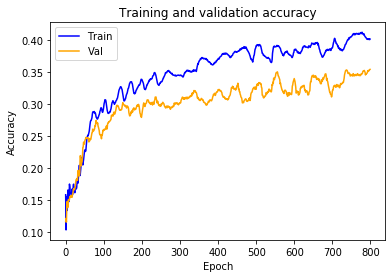

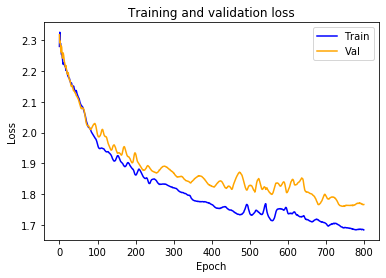

In [17]:
plot_history(history)

In [18]:
print(f"Final validation accuracy is: {history.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.355


In [19]:
file_path = git_root("models", "saved_models", "mfcc.h5")
net.save(file_path)